# Análise Exploratória dos Dados (_Exploratory Data Analysis_ - EDA)

__Autoria:__ Sabrina Paes Leme P. Correa (paeslemesa@gmail.com) <br>
__Criação:__ 16/04/2024 <br>
__Modificação:__ 25/04/2024

__Descrição:__ Este tutorial mostra como fazer uma análise exploratória de dados usando ferramentas estatísticas. A minha recomendação é usar este material como base, mas não se esqueça de explorar diferentes métodos e estatísticas.

__Referências:__ 
* https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

## 1. Importing libraries

In [11]:
from pathlib import Path # para manipulação de arquivos

import numpy as np # para manipulação de arrays

import pandas as pd # para manipulação de dataframes


# Vamos nos basear nestas três bibliotecas para alguns gráficos
import matplotlib.pyplot as plt # para plotar gráficos
import seaborn as sns # para plotar gráficos
import plotly.express as px # para plotar gráficos

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


from tqdm.auto import tqdm # para barra de progresso

import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.merge import merge
from rasterio.plot import show

c:\Users\paesl\anaconda3\envs\geopa2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
diretorio = Path(r"H:\Meu Drive\Artigo_Mestrado\00_Dados")

arquivo = Path(diretorio, "amostras_aoi.csv") 

# 2. Opening and adjusting dataset

In [14]:
df = pd.read_csv(arquivo) # abrindo o arquivo CSV
#df['evi'] = 2.5 * (df['nir'] - df['vermelho']) / (df['nir'] + 6 * df['vermelho'] - 7.5 * df['azul'] + 1)
df.head()

classe    azul   verde  vermelho     nir      ndvi
0       1  0.1299  0.1471    0.1240  0.4419  0.561760
1       1  0.1282  0.1414    0.1225  0.4151  0.544271
2       1  0.1326  0.1515    0.1264  0.4716  0.577257
3       1  0.1277  0.1460    0.1226  0.4781  0.591810
4       1  0.1278  0.1479    0.1214  0.4495  0.574707

In [15]:
df.groupby(by = "classe").count()

azul   verde  vermelho     nir    ndvi
classe                                          
1       101788  101788    101788  101788  101788
2        38246   38246     38246   38246   38246
3        35037   35037     35037   35037   35037
4        31571   31571     31571   31571   31571

In [16]:
min_val = df.groupby(by = "classe").count()['azul'].min()
min_val

np.int64(31571)

In [17]:
amostras = df.groupby(by='classe').sample( n = min_val, random_state= 42)
amostras.head()

classe    azul   verde  vermelho     nir      ndvi
4954         1  0.1262  0.1414    0.1244  0.4204  0.543319
150288       1  0.1212  0.1394    0.1184  0.4008  0.543914
82865        1  0.1212  0.1352    0.1176  0.3821  0.529318
32332        1  0.1376  0.1554    0.1349  0.4665  0.551380
151121       1  0.1224  0.1408    0.1185  0.4077  0.549601

## 3. Creation the model

In [28]:
amostras

classe    azul   verde  vermelho     nir      ndvi
4954         1  0.1262  0.1414    0.1244  0.4204  0.543319
150288       1  0.1212  0.1394    0.1184  0.4008  0.543914
82865        1  0.1212  0.1352    0.1176  0.3821  0.529318
32332        1  0.1376  0.1554    0.1349  0.4665  0.551380
151121       1  0.1224  0.1408    0.1185  0.4077  0.549601
...        ...     ...     ...       ...     ...       ...
15321        4  0.2208  0.2528    0.2902  0.3501  0.093550
146797       4  0.1638  0.1862    0.2222  0.3272  0.191118
73214        4  0.1688  0.1903    0.2198  0.3432  0.219183
93193        4  0.1486  0.1654    0.1792  0.3204  0.282626
101254       4  0.1496  0.1526    0.1672  0.2067  0.105643

[126284 rows x 6 columns]

In [18]:
X = amostras[['azul', 'verde', 'vermelho', 'nir', 'ndvi']]
y = amostras['classe']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
X_train

azul   verde  vermelho     nir      ndvi
70561   0.1726  0.1958    0.2214  0.3380  0.208438
85061   0.1209  0.1401    0.1207  0.3902  0.527500
191212  0.1348  0.1447    0.1318  0.1243 -0.029285
55742   0.1716  0.1958    0.2442  0.3607  0.192594
42556   0.1692  0.1929    0.2240  0.3302  0.191628
...        ...     ...       ...     ...       ...
34511   0.2302  0.2664    0.3514  0.3950  0.058414
1772    0.1638  0.1808    0.2124  0.3597  0.257472
113174  0.1192  0.1364    0.1176  0.3658  0.513446
134719  0.1198  0.1338    0.1204  0.3597  0.498438
80579   0.1515  0.1920    0.1954  0.3919  0.334582

[94713 rows x 5 columns]

In [20]:
model =  RandomForestClassifier(max_depth=2, random_state=42, n_estimators=100, criterion='gini', oob_score=True, n_jobs = 10)

model = model.fit(X_train, y_train)

In [21]:
y_pred = model.predict(X_test)

### 3.1. Accuracy Assessment

In [22]:
oob = model.oob_score_

In [23]:
print("OA:" ,accuracy_score(y_test, y_pred))
print("OOB score:", oob)
print(classification_report(y_test, y_pred, digits=4))

OA: 0.9665832567862912
OOB score: 0.9654007369632469
              precision    recall  f1-score   support

           1     0.9409    0.9895    0.9646      7905
           2     0.9996    0.9981    0.9989      7978
           3     0.9493    0.9310    0.9401      7871
           4     0.9776    0.9470    0.9621      7817

    accuracy                         0.9666     31571
   macro avg     0.9669    0.9664    0.9664     31571
weighted avg     0.9669    0.9666    0.9665     31571



In [24]:
# Print gini importances
importances = model.feature_importances_
for i, col in enumerate(X.columns):
    print(f"{col}: {importances[i]:.4f}")

azul: 0.0613
verde: 0.1933
vermelho: 0.1599
nir: 0.2655
ndvi: 0.3200


In [43]:
conf = confusion_matrix(y_test, y_pred)
conf

array([[7822,    0,   83,    0],
       [  10, 7963,    0,    5],
       [ 378,    0, 7328,  165],
       [ 103,    3,  308, 7403]], dtype=int64)

In [75]:
def commision_omission_errors(conf):
    n_classes = conf.shape[0]

    OE = []
    CE = []

    i= 0
    for i in range(n_classes):
        OE.append((np.sum(conf[i,:])-conf[i,i])/np.sum(conf[i,:]))
        CE.append((np.sum(conf[:,i])-conf[i,i])/np.sum(conf[:,i]))
    dict = {'class': range(1, n_classes +1), 'OE%': OE, 'CE%': CE}

    return pd.DataFrame(dict)


In [76]:
erros = commision_omission_errors(conf)
erros['OE%'] = erros['OE%']*100
erros['CE%'] = erros['CE%']*100

erros


class       OE%       CE%
0      1  1.049968  5.906412
1      2  0.188017  0.037660
2      3  6.898742  5.065423
3      4  5.296149  2.244817

## 4. Classifying the image

In [47]:
img_folder = r"D:\Pesquisa\Artigo_Mestrado\01_Imagens\Sentinel2\Tiles"
out_folder = r"D:\Pesquisa\Artigo_Mestrado\02_Classificacao_1"

In [48]:
img_list = list(Path(img_folder).glob("*.tif"))

In [84]:
for i in tqdm(range(len(img_list))):

    with rasterio.open(img_list[i]) as src:
        img = src.read()
        profile = src.profile

    img = img/10000

    ndvi = (img[3] - img[2]) / (img[3] + img[2])
    #evi = 2.5 * (img[3] - img[2]) / (img[3] + 6 * img[2] - 7.5 * img[0] + 1)

    img = np.concatenate((img, ndvi[np.newaxis, :, :]), axis=0)


    img2 = reshape_as_image(img)
    X = np.reshape(img2, (img2.shape[0]*img2.shape[1], img2.shape[2]))

    y_pred_img = model.predict(X)

    y_final = y_pred_img.reshape(img[0].shape)[np.newaxis, :, :]

    name_out = Path(out_folder, img_list[i].stem + "classificacao.tif")

    profile.update(count = 1,
                    dtype = 'uint8',
                    compress = 'lzw',
                    nodata = 0)

    with rasterio.open(name_out, 'w', **profile) as dst:
        dst.write(y_final.astype('uint8'))



  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\paesl\anaconda3\envs\yolo4D\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Mergin images

In [87]:
list_classified = list(Path(out_folder).glob("*classificacao.tif"))

class_src = []

for file in list_classified:
    class_src.append(rasterio.open(file))

In [90]:
mosaic, out_trans = merge(class_src)

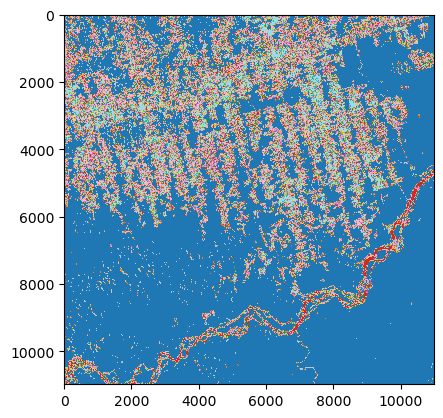

<Axes: >

In [93]:
show(mosaic, cmap='tab20')

In [95]:
profile = {
    "count":1,
    "dtype": 'uint8',
    "compress": 'lzw',
    "nodata": 0,
    "transform": out_trans,
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
}

profile

{'count': 1,
 'dtype': 'uint8',
 'compress': 'lzw',
 'nodata': 0,
 'transform': Affine(10.0, 0.0, 799980.0,
        0.0, -10.0, 9600040.0),
 'height': 10980,
 'width': 10980}